In [26]:
using Pkg; Pkg.activate("."); 
using StatsBase
using Revise
import MUST
using PyPlot
using Interpolations
using PyCall
using KernelDensity
using DelimitedFiles

#MUST.@import_dispatch "/u/peitner/DISPATCH/dispatch2"
MUST.@import_dispatch "/shared-storage/eitner/model_grid/dispatch2"

MUST.@get_help visual
pl = pyimport("matplotlib.pylab")

  Activating environment at `/usr/local/autofs.shared/shared-storage/eitner/model_grid/MUST.jl/examples/solar_model/Project.toml`


PyObject <module 'matplotlib.pylab' from '/usr/local2/misc/anaconda/anaconda3-py38/lib/python3.8/site-packages/matplotlib/pylab.py'>

In [27]:
eos_path = "input_data/solar_lte"
eos_path = "input_data/TSO_sun_Magg_v10.2"
sqEOS    = MUST.SquareGasEOS(MUST.@in_dispatch(eos_path));

The stagger model to compare with

In [28]:
folder_stagger = "/ptmp/peitner/model_grid/MUST.jl/examples/stagger2bifrost"
stagger        = MUST.Box("box_solar_stagger_LegacyStagger", folder=folder_stagger);
stagger_τ      = MUST.Box("box_solar_stagger_LegacyStagger_t", folder=folder_stagger);

In [29]:
model = readdlm("../initial_conditions/stagger_av.dat", skipstart=2)
z_goal, T_goal, d_goal = -model[:, 1], model[:, 2], model[:, 3];

In [30]:
folder1 = MUST.@in_dispatch "data/TSO_sun_v10.2_TDZ4"
folder1 = MUST.@in_dispatch "data/LEG_sun_test_TDZ_corr"
model, model_t = MUST.Boxes(folder1, snaps=[4]);

In [31]:
label1 = "model"

"model"

In [32]:
function shift_z!(model)
    optical_surface = MUST.height_where(; τ_ross=1.0)                 # function that interpolates height where lgtau=0
    surf_model      = MUST.reduce_by_column(optical_surface, model);  # Reduce data cube to plane by interp. in height according to optical surface 
    model.z = model.z .- MUST.plane_statistic(mean, surf_model, :z)   # Align the z axis such that the point is at this average depth
end

shift_z! (generic function with 1 method)

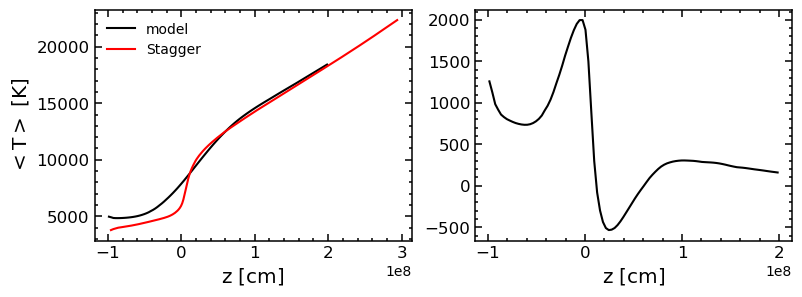

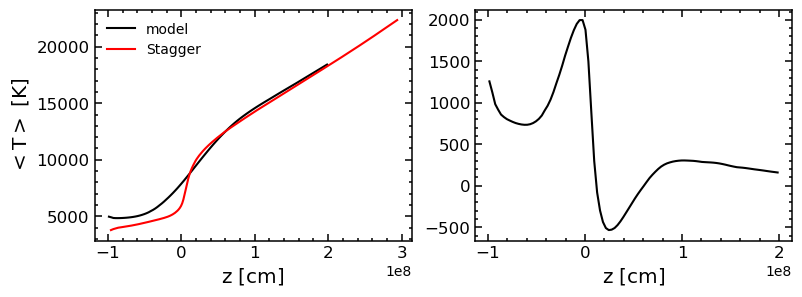

In [33]:
d = MUST.plane_statistic(mean, model, :T)
d_stagger  = MUST.plane_statistic(mean, stagger, :T)
r_stagger = MUST.plane_statistic(mean, stagger, :d)

z = MUST.axis(model, :z)
z_stagger  = MUST.axis(stagger, :z)

d_ip = Interpolations.linear_interpolation(z_stagger, d_stagger, extrapolation_bc = Line())(z)


# Plotting
close()
f, ax = plt.subplots(1, 2, figsize=(9,3))
basic_plot!.(ax)


## The temperature profile
ax[1].plot(-z, d, color="k", label=label1)
ax[1].plot(-z_stagger,  d_stagger,  color="r", label="Stagger")

## absolute difference
ax[2].plot(-z, d .- d_ip, color="k", label="Dispatch")


ax[1].set_ylabel(L"\rm <T> \ [K]", fontsize="x-large")
ax[1].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax[2].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")

ax[1].legend(framealpha=0, loc="upper left", fontsize="medium");

gcf()

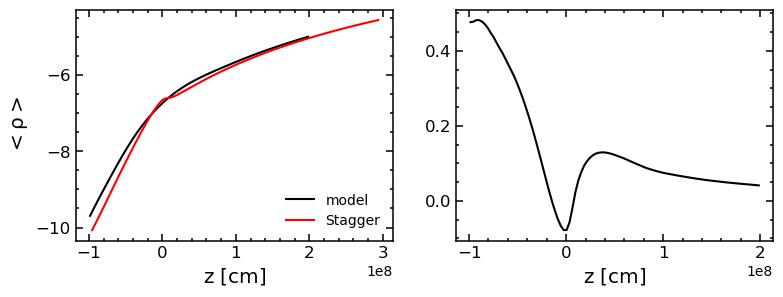

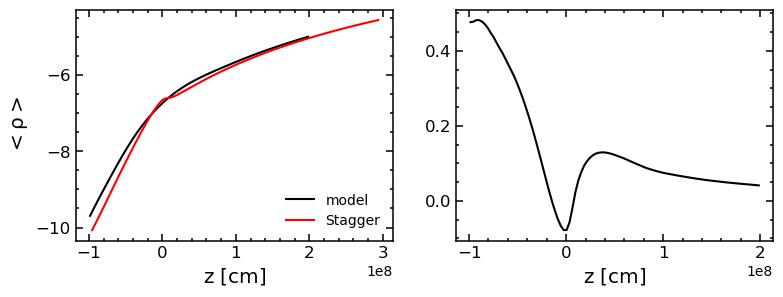

In [34]:
d = log10.(MUST.plane_statistic(mean, model, :d))
d_stagger  = log10.(MUST.plane_statistic(mean, stagger, :d))

r_stagger = MUST.plane_statistic(mean, stagger, :d)

z = MUST.axis(model, :z)
z_stagger  = MUST.axis(stagger, :z)

d_ip = Interpolations.linear_interpolation(z_stagger, d_stagger, extrapolation_bc = Line())(z)


# Plotting
close()
f, ax = plt.subplots(1, 2, figsize=(9,3))
basic_plot!.(ax)


## The temperature profile
ax[1].plot(-z, d, color="k", label=label1)
ax[1].plot(-z_stagger,  d_stagger,  color="r", label="Stagger")

## absolute difference
ax[2].plot(-z, d .- d_ip, color="k", label="Dispatch")


ax[1].set_ylabel(L"\rm <\rho>", fontsize="x-large")
ax[1].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax[2].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")

ax[1].legend(framealpha=0, loc="lower right", fontsize="medium");

gcf()

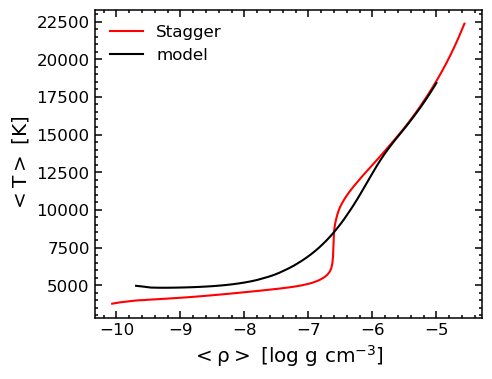

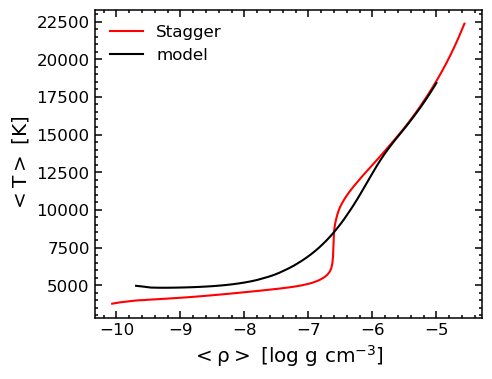

In [35]:
d = MUST.plane_statistic(mean, model, :T)
d_stagger  = MUST.plane_statistic(mean, stagger, :T)

d2 = log10.(MUST.plane_statistic(mean, model, :d))
d2_stagger  = log10.(MUST.plane_statistic(mean, stagger, :d))

# Plotting
close()
f, ax = plt.subplots(1, 1, figsize=(5,4))
basic_plot!(ax)


## The temperature profile
ax.plot(d2_stagger,  d_stagger,  color="r", label="Stagger")
ax.plot(d2, d, color="k", label=label1)


ax.set_ylabel(L"\rm <T> \ [K]", fontsize="x-large")
ax.set_xlabel(L"\rm <\rho> \ [log\ g\ cm^{-3}]", fontsize="x-large")

ax.legend(framealpha=0, loc="upper left", fontsize="large");

gcf()

In [36]:
126.6627 * 1e-7

1.2666269999999999e-5

# Comparison on $\tau_{ross}$ scale
Convert the boxes to $\tau_{ross}$ height scale. Do not impose boundaries to avoid extrapolation, let the resolution of the model itself define the limits of the axes.

In [37]:
stagger_τ  = stagger_τ
tab_τ = model ;

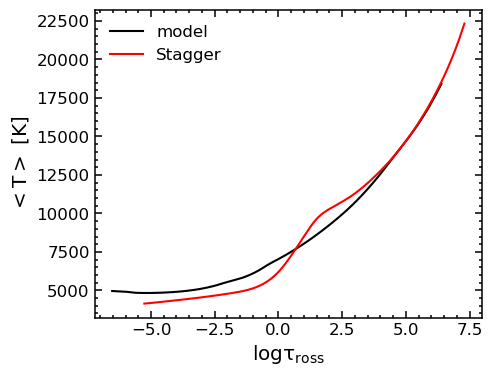

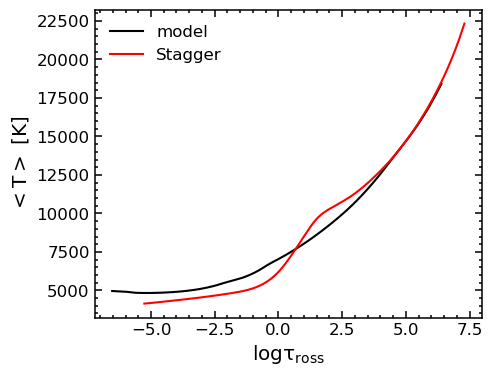

In [38]:
d = MUST.plane_statistic(mean, tab_τ, :T)
d_stagger  = MUST.plane_statistic(mean, stagger_τ, :T)

z = log10.(MUST.axis(tab_τ, :τ_ross, 3))
z_stagger  = log10.(MUST.axis(stagger_τ, :τ_ross, 3))

# Plotting
close()
f, ax = plt.subplots(1, 1, figsize=(5,4))
basic_plot!(ax)


ax.plot(z, d, color="k", label=label1)
ax.plot(z_stagger,  d_stagger,  color="r", label="Stagger")


ax.set_ylabel(L"\rm <T> \ [K]", fontsize="x-large")
ax.set_xlabel(L"\rm log \tau_{ross}", fontsize="x-large")

ax.set_xlim(-6, 4.0)
ax.set_ylim(3000, 12500)

ax.legend(framealpha=0, loc="upper left", fontsize="large");

gcf()

In [39]:
b1 = last(MUST.Boxes(folder1))

var = :d
paths = []

for i in eachindex(b1)
    d = MUST.plane_statistic(mean, b1[i], var)
    d_stagger  = MUST.plane_statistic(mean, stagger_τ, var)

    z = log10.(MUST.axis(b1[i], :τ_ross, 3))
    z_stagger  = log10.(MUST.axis(stagger_τ, :τ_ross, 3))

    # Plotting
    close()
    f, ax = plt.subplots(1, 1, figsize=(5,4))
    basic_plot!(ax)

    ax.set_title("snapshot $(i)")

    ax.plot(z, d, color="k", label=label1)
    ax.plot(z_stagger,  d_stagger,  color="r", label="Stagger")

    ax.set_ylabel(L"\rm <T> \ [K]", fontsize="x-large")
    ax.set_xlabel(L"\rm log \tau_{ross}", fontsize="x-large")
    ax.set_yscale("log")


    ax.legend(framealpha=0, loc="upper left", fontsize="large");
    f.savefig("mtemp_$(i).png")
    append!(paths, ["mtemp_$(i).png"])

    plt.close()
end

gif_from_pngs(paths, "comp_T_stagger.gif", duration=0.5);